In [17]:
#Optional: install requirements from the conda requirements file in the GitHubRepo when using code locally, or run the code below to get packages
#googletrans should be version 3.0.0 but may change if google updates the API
!pip install googletrans
!pip install nltk==3.7
!pip install pypdf==3.4.1


# PDF-to-text

In [ ]:
from glob import glob
from pypdf import PdfReader
from tqdm import tqdm
import traceback
import os

def convert_pdfs():
    """
    Function to read all PDFs in a folder specified within the function and to create a new folder called "texts" that contains text files with their content
    %PAGEBREAK% will be inserted framed with two newlines on each end to make page breaks
     If PDF-to-text fails, the stacktrace will be printed immediately and filenames will be recorded and printed at the end of the function.
    :return: None
    """

    files=glob('2022 Evaluation Reports/*.pdf')
    problem_files=[]

    for f in tqdm(files):
        new_name=os.path.join('texts', f.split('\\')[1].replace('.pdf','.txt'))#new file name
        txts=[]
        try:
            try:
                reader = PdfReader(f)
            except:
                print("Problem with reader..")
                pass

            for p in reader.pages:
                text = p.extract_text()
                txts.append(text+'\n\n%PAGEBREAK%\n\n')
            with open(new_name,'w', encoding='utf-8') as outf:
                outf.writelines(txts)
        except:

            print(f)
            print(traceback.format_exc())
            print('################')
            problem_files.append(f)

    print("Files that weren't converted due to any issue:")
    print(problem_files)
    print(len(problem_files))




convert_pdfs()


# Section identification using regex

In [ ]:
from glob import glob
import statistics
import re
import os
import nltk


def get_contents(pages, category='summary', name='1234.pdf'):
    conts=r'(\bcontent*)|(\bMATIÈRES)|(\bCONTEÚDO)|(\bÍNDICE)'#Table of contents (TOC) regex
    ll=r'(\bLESSONS)|(\bLições)|(\bleçon)|(\blecciones)|(GOOD PRACTICE)'#lessons learned section
    conc=r'(\bconclusio)|(\bconclusõ)'#conclusions
    findings=r'(\bresultados)|(\bmain finding)|(\bfindings)|(resultat)'#findings section
    recs=r'(\brecommendatio)|(\bRecomendaçõ)|(\brecomendaci)|(RECOMMANDATIO)'#recommendation section
    others=r'(REFERENCES)|(index of)|(\bacronym)|(\babbreviation)|(\bACRÔNIMO)|(\bliste des)|(\bgraphiques)|(\bLISTA DAS)|(\bfiguras)|(\bannex)|(\bApêndic)|(\bappendi)|(\banexo)|(Méthodolog)|(Principaux constats)|(Introduct)|(METHODOLO)|(EVALUATION PURPOSE)|(EVALUATION OBJECT AND CONTEXT)|(BACKGROUND)|(Hallazgos)|(metodológic)|(objetivos)|(Antecedentes)|(Evaluation Design)|(Evaluation Purpose)|(Country and Operational Context)|(THEORY OF CHANGE)|(EVALUATION OBJECT)'
    sum=r'(executive summary)|(RESUMEN EJECUTIVO)|(RÉSUMÉ EXECUTIF)|(Résumé exécutif)|(SOMMAIRE EXECUTIF)|(Resume executif)'#Executive summary section

    all_regexes={'TOC':conts,'summary':sum, 'recommendations':recs, 'findings':findings, 'conclusions':conc, 'lessons':ll, 'others':others}


    passages=[]

    print('Report has {} pages'.format(len(pages)))

    ######################sectionalisation
    sections=[]
    for p in pages:
        p=re.sub(r'^\d\s+$', '',p)#remove page numbers
        if '\n\n' in p:
            secs=p.split('\n\n')
        else:
            secs=p

        for s in secs:
            parts=re.split('^(\d+\.?|[xiv])+\s+', s, re.IGNORECASE)
            for pa in parts:
                sections.append(pa)

    found_summary=False
    found_other=False

    max_words=5000
    word_count=0

    print('Report has {} sections'.format(len(sections)))
    ###########################################################identification of sections of interest
    other_sections = all_regexes.copy()
    del (other_sections[category])

    for sec in sections:
        ################executive summary
        if not re.search(all_regexes['TOC'], sec[:100], re.IGNORECASE) and not '....' in sec[:100]:#dont search in table of contents section, which often has loads of dots '...'
            lines=sec.split('\n')
            for l in lines:
                if found_summary==False and word_count<max_words:
                    if re.search(all_regexes[category], l, re.IGNORECASE) and len(l)<70:#trying to see if this is a header line (less than 70 characters) that matches our category heading
                        found_summary=True
                        tt = sec.replace('\n', ' ').replace('  ', ' ')
                        if tt not in passages:
                            passages.append(tt)
                            word_count+=len(nltk.tokenize.word_tokenize(tt))


                        break
            if found_summary==True:
                if word_count<max_words:
                    matches=False

                    if '. . .' not in sec[:100] or '.....' not in sec[:100] or not re.search(other_sections['TOC'],sec[:100], re.IGNORECASE):

                    # for v in other_sections.values():
                    #     if re.search(v,sec[:100], re.IGNORECASE):
                    #         matches=True
                    #         found_summary == False#keep on searching, incase we went into a trap in the table of contents or elsewhere
                        if not matches:
                            tt = sec.replace('\n', ' ').replace('  ', ' ')
                            if tt not in passages:
                                passages.append(tt)
                                word_count+=len(nltk.tokenize.word_tokenize(tt))



    new_name = os.path.join(category, name.split('\\')[1])  # new file name, save all sectionalised text in a new directory
    print(new_name)
    print(word_count)
    # with open(new_name, 'w', encoding='utf-8') as ff:
    #     ff.writelines(passages)

    if len(passages)>3:
        return 1

    else:
        return 0


##################################tables of content
    # for p in range(0,13):
    #     #Tried to identify table of contents directly but too heterogeneous so method may be useless
    #     txt=pgs[p]
    #     if 'table of contents' in text.lower() or re.search(conts, txt[:50], re.IGNORECASE):
    #
    #
    #         if not re.search(annex, pgs[p+1], re.IGNORECASE) and not re.search(acronyms_and_co, pgs[p+1], re.IGNORECASE):
    #             txt=txt+'\n'+pgs[p+1]
    #             print('no annex')
    #             print(txt)
    #         elif re.search(annex, pgs[p+1], re.IGNORECASE):
    #             x=re.split(annex, pgs[p+1], re.IGNORECASE)
    #             txt = txt + '\n' + x[0]
    #             print('found annex')
    #             print(txt)
    #         elif re.search(acronyms_and_co, pgs[p+1], re.IGNORECASE):
    #             x=re.split(acronyms_and_co, pgs[p+1], re.IGNORECASE)
    #             txt = txt + '\n' + x[0]
    #             print('found others')
    #             print(txt)
    #         return txt





text_dir='texts/*.txt'#directory pointing towards PDF-extracted texts
files=glob(text_dir)
print('Found {} text files.'.format(len(files)))

num_pages=[]
failed=[]

summary_counter=0
for path in files:
    with open(path, 'r', encoding='utf-8') as f:#for each file, separate the pages out and run the section identification method
        text=f.read()
    pages=text.split('%PAGEBREAK%')
    num_pages.append(len(pages))

    ############################Table of contents
    print('-----------------------------------------')
    print(path)
    counts=get_contents(pages,category='summary', name=path)#get the executive summary section. See method for all section and regexes
    #counts=get_contents(pages,category='lessons', name=path)#lessons learned section

    if counts==0:
        failed.append(path)
    summary_counter+=counts

    print('-----------------------------------------')
    # for p in range(0,10):
    #     page = reader.pages[p]
    #     text = page.extract_text()
    #     if 'table of contents' in text.lower() or re.search(r'\bcontent', text[:50], re.IGNORECASE):
    #         print(text)


print(summary_counter)
pages_average=statistics.mean(num_pages)
pages_std=statistics.stdev(num_pages)
print('{} +- {} pages'.format(pages_average, pages_std))
num_pages.sort()
failed=[f.split('\\')[1] for f in failed]

for f in failed:
    print(f)

# Creating input file for BERT model training and testing

The input files are simple text files where raw text from the PDF-extraction files was copied. As long as each class has a separate text file such as the one in the picture with sentences from various evaluations, the script will take care of formatting it into a proper csv spreadsheet with labels. Train/test splits will be applied in the actual code used for training in another function.[link text](https://)

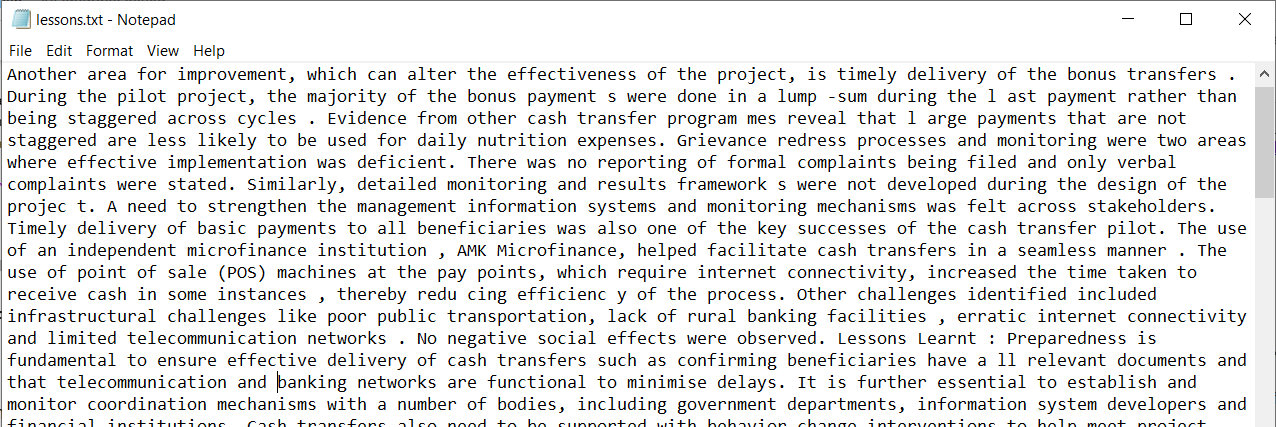


In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
train_file=pd.read_csv(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\train\train_UNICEF_1.csv',encoding = "ISO-8859-1",skip_blank_lines=True)
train_file.dropna(how="all", inplace=True)
train_file.fillna('')
train_file['background']=0
def remove_errors(l):
    errs = ['\uf0b7', '\ufeff']
    for e in errs:
        l=l.replace(e,"")
    l=l.replace('%PAGEBREAK%', '\n')
    return l

def add_lines(path, cls, df):
    with open(path,'r', encoding='utf-8') as f:
        txt=f.read()

    lines=[remove_errors(l) for l in nltk.tokenize.sent_tokenize(txt)]
    lines=[l for l in lines if len(l) > 10]

    rowlist=[]
    print(df.shape)
    for l in lines:
        rw={k:0 for k in list(df.columns)}
        rw['comment_text']=l
        rw[cls]=1
        rowlist.append(rw)
        #print(rw)
    df= df.append(rowlist, ignore_index=True)
    print(df.shape)
    return df

####convert text files to training points
train_file= add_lines(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\train\recommendation.txt', 'recommendation', train_file)
train_file= add_lines(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\train\enablers.txt', 'enablers', train_file)
train_file= add_lines(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\train\barriers.txt', 'barriers', train_file)
train_file= add_lines(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\train\lessons.txt', 'lessons', train_file)
train_file= add_lines(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\train\background.txt', 'background', train_file)

ids=[i for i,n in enumerate(train_file['id'])]#assign unique ID
train_file['id']=ids


train_file.to_csv(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\train\train_UNICEF.csv', index=False)

# Automated translations
This script has methods to translate full PDF-ectracted texts, a method to translate only the executive summary texts, and a method to translate data from a specific column in a spreadsheet. This is needed because the sentence-mining BERT model is trained on english text with our dataset so it doesn't make sense to send spanish/french at downstream prediction. Also we decided to use machine-translated text throughout this project anyway, even for data extraction.

To avoid over-using the Google API, with bigger texts the functions check a number of random sentences sampled from each input document and run translation if the majority don't evaluate as English as per the google translate api

In [ ]:
import os.path

import pandas as pd
from googletrans import Translator
from glob import glob
import nltk
from tqdm import tqdm
import time
import random

translator = Translator(service_urls=['translate.googleapis.com'])
# print(translator.translate('Der Himmel ist blau und ich mag Bananen', dest='en'))#TEST if API works. This should print something like: "The sky is blue and I like bananas."

filepath=r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\tagging\tagging_feb23.csv'
df=pd.read_csv(filepath).fillna('')


df=df[df['Language']!= 'English']#get nonenglish records as per spreadsheet
print('Got {} non-english records, '.format(df.shape))
print(df['Language'].value_counts())
ids=df['ID#']
all_fulltexts=glob(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\texts\*.txt')


print(len(all_fulltexts))
print(all_fulltexts[0])
counter=0

###########################translate all text marked as non-english texts within UNICEF dataset (this may be incomplete which is why the method is commented. Use other methods in this script.)
# for i in tqdm(ids):#for each id with text other than english
#
#     for p in all_fulltexts:
#         ##############################prepare text by reading it and sent-tokenizing
#         if '\{}.txt'.format(i) in p:#find the pdf-extracted text file and read it below
#
#             ###############check if translation exists from earlier run
#             if os.path.exists(os.path.join('translated_fulltexts', '{}.txt'.format(i))):
#                 print(os.path.join('translated_fulltexts', '{}.txt')+' EXISTS')
#             else:
#
#
#
#                 with open(p, 'r', encoding='utf-8') as f:
#                     text = f.read()
#                 pages = text.split('%PAGEBREAK%')#look at it page-wise
#                 lines=[]
#                 for pg in pages:
#                     pg_sents    = [l for l in nltk.tokenize.sent_tokenize(pg)]
#                     pg_sents.append('%PAGEBREAK%')
#                     lines.extend(pg_sents)
#
#                 newlines = []
#                 current = ''
#
#                 for l in lines:
#                     if '%PAGEBREAK%' in l:
#                         newlines.append(current)
#                         newlines.append(l)
#                         current = ''
#                     else:
#                         current = current + ' ' + l
#                 newlines.append(current)
#
#
#                 ####################################translate
#                 sents_translated=[]
#                 for sent in newlines:
#                     if '%PAGEBREAK%' in sent:
#                         sents_translated.append('%PAGEBREAK%')
#                     else:
#                         #print(sent)
#
#                         #print('------------------------------')
#                         try:
#                             translated=translator.translate(sent, dest='en').text
#                         except:
#                             sents_translated=['Error']
#                             print('error in {}'.format(i))
#                             print('Sleeping and retrying')
#                             time.sleep(30)
#                             break
#                             #translated = translator.translate(sent, dest='en').text
#                         #print(translated)
#                         sents_translated.append(translated)
#                         #print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<.......>>>>>>>>>>>>>>>>>>>>>>>>>')
#                 with open(os.path.join('translated_fulltexts', '{}.txt'.format(i)), 'w', encoding="utf-8") as outfile:
#                     outfile.writelines(sents_translated)
#
#
#
# print(counter)


######################################check all remainng documents and translate if needed
def check_language(
        all_fulltexts):  # check to see if any of the unicef reports not officially marked as other language do actually include non-english text.
    all_translated = glob(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\translated_fulltexts\*.txt')
    tr_ids = [i.split('\\')[-1].replace('.txt', '') for i in all_translated]
    print(len(tr_ids))
    is_in = 0
    not_in = 0

    for ft in all_fulltexts:#this is a list of file names that were included in the project (as the folder with the texts also included non-relevant evaluations) remove this if you want to translate every document
        ft_id = ft.split('\\')[-1].replace('.txt', '')
        if ft_id not in tr_ids:  # no translation exiss
            with open(ft, 'r', encoding='utf-8') as f:
                text = f.read()
                pages = text.split('%PAGEBREAK%')  # look at it page-wise
                lines = []
                for pg in pages:
                    pg_sents = [l for l in nltk.tokenize.sent_tokenize(pg)]
                    pg_sents.append('%PAGEBREAK%')
                    lines.extend(pg_sents)

                newlines = []
                current = ''

                for l in lines:
                    if '%PAGEBREAK%' in l:
                        newlines.append(current)
                        newlines.append(l)
                        current = ''
                    else:
                        current = current + ' ' + l
                newlines.append(current)

                #######check if article is non-english:
                sents = [s for s in newlines if '%PAGEBREAK%' not in s]
                try:
                    test = random.sample(sents, 5)#check 5 random sents and translate only if the majority isn't english
                    langs = [str(translator.detect(s).lang) for s in test]
                    print('----')
                    print('Checking: {}'.format(test))
                    print(langs)
                except:
                    print('exception at {}'.format(ft_id))
                    langs=['en', 'en', 'en', 'en', 'en']

                if max(set(langs), key=langs.count) != 'en':  # if majority of samples are not english
                    ####################################translate

                    print('Translating it.. ')
                    sents_translated = []
                    for sent in newlines:
                        if '%PAGEBREAK%' in sent:
                            sents_translated.append('%PAGEBREAK%')
                        else:
                            # print(sent)

                            # print('------------------------------')
                            try:
                                translated = translator.translate(sent, dest='en').text
                            except:
                                sents_translated = ['Error']
                                print('error in {}'.format(ft_id))
                                print('Sleeping and retrying')
                                time.sleep(30)
                                break
                                # translated = translator.translate(sent, dest='en').text
                            # print(translated)
                            sents_translated.append(translated)
                            # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<.......>>>>>>>>>>>>>>>>>>>>>>>>>')
                    with open(os.path.join('translated_fulltexts', '{}.txt'.format(ft_id)), 'w',
                              encoding="utf-8") as outfile:
                        outfile.writelines(sents_translated)


        else:
            pass


def check_summaries():
    sum_path=r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\summary_complete\*.txt'
    new_sums=r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\summary_translated'

    all_translated = glob(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\summary_translated\*.txt')
    tr_ids = [i.split('\\')[-1].replace('.txt', '') for i in all_translated]


    # print(glob(sum_path))
    # print('--')
    for ft in glob(sum_path):
        ft_id = ft.split('\\')[-1].replace('.txt', '')

        if ft_id in tr_ids:
            print('Skip')
        elif ft_id not in tr_ids:
            with open(ft, 'r', encoding='utf-8') as f:
                text = f.read()

                pages = text.split('%PAGEBREAK%')  # look at it page-wise
                lines = []

                for pg in pages:
                    pg_sents = [l for l in nltk.tokenize.sent_tokenize(pg)]
                    pg_sents.append('%PAGEBREAK%')
                    lines.extend(pg_sents)


                newlines = []
                current = ''

                # for l in lines:
                #     if '%PAGEBREAK%' in l:
                #         newlines.append(current)
                #         newlines.append(l)
                #         current = ''
                #     else:
                #         current = current + ' ' + l
                # newlines.append(current)

                #######check if article is non-english:
                sents = [s for s in lines if '%PAGEBREAK%' not in s]
                # try:

                if len(sents)>10:#check 10 random sentences to determine if the file needs translation
                    test = random.sample(sents, 10)
                else:
                    test=sents
                    if test==[]:
                        test=['']


                langs = [str(translator.detect(s).lang) for s in test]
                if len(langs)==0:#if there is no content or something went wrong
                    langs = ['fr', 'fr', 'fr', 'fr', 'fr']

                print('----')
                print('Checking: {}'.format(test))
                print(langs)
                # except:
                #     print('exception at {}'.format(ft_id))
                #     langs = ['en', 'en', 'en', 'en', 'en']

                if max(set(langs), key=langs.count) == 'en':
                    with open(os.path.join(new_sums, '{}.txt'.format(ft_id)), 'w',encoding="utf-8") as outfile:
                        outfile.writelines(text.replace('%PAGEBREAK%', '\n'))

                elif max(set(langs), key=langs.count) != 'en':  # if majority of samples are not english
                    ####################################translate

                    print('Translating {}.. '.format(ft_id))
                    sents_translated = []

                    new_lis = []############merge 20 sentences together to reduce number of API calls
                    part = []
                    print(len(sents))
                    for l in sents:
                        if len(part) < 19:
                            part.append(l)
                        else:
                            part.append(l)
                            new_lis.append(' '.join(part))
                            part = []
                    new_lis.append(' '.join(part))
                    print(len(new_lis))
                    print('xx')
                    for sent in tqdm(new_lis):

                            try:
                                translated = translator.translate(sent, dest='en').text
                            except:
                                sents_translated = ['Error']
                                print('error in {}'.format(ft_id))
                                print('Sleeping and retrying')
                                time.sleep(30)
                                break
                                # translated = translator.translate(sent, dest='en').text
                            # print(translated)
                            sents_translated.append(translated)
                            # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<.......>>>>>>>>>>>>>>>>>>>>>>>>>')

                    with open(os.path.join(new_sums, '{}.txt'.format(ft_id)), 'w',encoding="utf-8") as outfile:

                        outfile.writelines(sents_translated)
                        print(sents_translated)
                        time.sleep(3)


def translate_spreadsheet():
    df_old = pd.read_csv(r'C:\Users\c1049033\Documents\unicef\analysis_examples\new_tags_v3.csv').fillna('')
    df = pd.read_csv(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\tagging\tagging_feb23.csv').fillna('')
    def do_trans(sent):
        try:
            translated = translator.translate(sent, dest='en').text
        except:
            print('except {}'.format(sent))
            translated=sent
        return translated
    df['translation']=[do_trans(sent) for sent in list(df["Description"])]
    time.sleep(10)
    df_old['translation'] = [do_trans(sent) for sent in list(df_old["Description"])]

    df_old.to_csv(r'C:\Users\c1049033\Documents\unicef\analysis_examples\new_tags_v3.csv', index=False)
    df.to_csv(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\tagging\tagging_feb23.csv', index=False)

check_language(all_fulltexts)
check_summaries()
translate_spreadsheet()



# SWIFT-Review import and analysis related helper scripts
This code may be less applicable to projects re-using out code. Here, we have functions to take the data from the UNICEF spreadsheet and make SWIFT-Review batch queries for transferring data into the software (more info here: https://www.sciome.com/swift-review/ ). Note: This code merges data from various spreadsheets on some conditions that may not apply in future projects, so take care when adapting it. In some cases it may be easier to rewrite the methods from scratch for new datasets because this code is specific to fields in UNICEF's EISI database. Sorry!

We also have a helper script that takes text from various folders (extracted summary sections, auto-translated text) and merges/writes the info for every document into a RIS file so that it can be used with other tools. In our case, we created the RIS file and used it in SWIFT-Review. AGAIN, this may be rather specific to UNICEF EISI database fields...

In [ ]:
import glob

import pandas as pd
import re
import os
from util import includes_2022##filter down to the 631 that will be included. This is just a list of IDS as integers included in our project and may need to be removed or altered when re-used in a new project
#the includes_2022 variable looks something like this in our case, but will need to be removed from the code or changed in different projects: [123, 3345, 2245]

def make_swift_queries():#note batch query files are also created within the big main method, the method here is an older one but it is specific to batch queries
    filepath = r'C:\Users\c1049033\Documents\unicef\swift\new_tags_v3.csv'
    filepath = r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\tagging\tagging_feb23.csv'

    df = pd.read_csv(filepath).fillna("")
    print(df.columns)
    ignore = ["Title", "Sector", "Description", "WBS Code"]
    alphacols = [
        "Strategic Plan Goals"]  # all letters will be replaced so that we end up only with goals (numeric, non-alpha characters)

    def preprocess(value, rep_alpha=False):
        initial = value
        value = str(value)
        value = value.lower().strip()
        value = value.replace("  ", " ").replace(" ", "_")  # pythonification :)
        if not rep_alpha:
            value = re.sub('[^0-9a-zA-Z\_]+', '', value)
        else:
            value = re.sub('[^0-9\_]+', '', value)
        value = value.replace("__", "_")
        if value == "":
            value = "Empty"
        return value

    problems = []
    for col in df.columns:  # create tagsets for all columns of interest (todo: this tags unique entries, need to ignore cols like the Goals column and implement a set-based approach, since ' Goal 1, Goal 4' is not a single tag, but rather 2 separate tags
        if col not in ignore:
            if col in alphacols:
                replace_alpha = True
            else:
                replace_alpha = False
            print('{}: {}'.format(col, len(df[col].unique())))
            categories = list(df[
                                  col].unique())  # unique values are tag categories, eg. ifn ountry office, Uganda is a tag and all Uganda records get aggregated below it
            categories = list(
                set(preprocess(c, replace_alpha) for c in categories if preprocess(c, replace_alpha) != ""))
            foldername = os.path.join("batch_files_v4", preprocess(col))
            datadict = {k: [] for k in
                        categories}  # placeholder for each tag (unique value) within a category (spreadsheet column)

            if not os.path.exists(foldername):
                os.makedirs(foldername)

            # for s in df[col].iteritems():
            #     cat=preprocess(s[1],replace_alpha)#clean each item in series and append it to the dict
            #     datadict[cat].append(s[0])
            for i, row in df.iterrows():
                cat = preprocess(row[col], replace_alpha)  # clean each item in series and append it to the dict
                datadict[cat].append(row['ID#'])

            for cat, v in datadict.items():

                filename = os.path.join(foldername, cat + ".txt")
                try:
                    with open(filename, 'w') as f:
                        ids = ['journal:{}'.format(x) for x in
                               v]  # create a search string in SWIFT-Review format that will be used as batch query to tag the correct documents
                        f.write(" OR ".join(ids))
                except:
                    problems.append(filename)
    print(problems)


# make_swift_queries()

def get_fulltexts(this_id, path_to_txts=r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\texts'):
    files = glob.glob(os.path.join(path_to_txts, '*.txt'))
    files = [f.split('\\')[-1] for f in files]
    filename = os.path.join(path_to_txts, '{}.txt'.format(this_id))
    txt = ''

    if os.path.exists(filename):
        with open(filename, 'r', encoding='utf-8') as f:
            txt = f.read()
        txt = txt.replace('%PAGEBREAK%', '').replace('\n\n', '\n').replace('  ', ' ')
    return txt


def make_ref_file(full_path="", name="", use_abstract=True, use_summary=True, use_translate=True):
    batch_queries = {'Year': {}, 'Office': {}, 'GEROS Rating': {}, 'Language': {}, 'Category': {}, 'Case study': {},
                     'Strategic Plan Goals': {}, 'Region': {}}
    print(batch_queries.keys())

    #############################Convert the spreadsheet into a RIS file that can be loaded into SWIFT, so that docs can be tagged using the batch queries
    df_old = pd.read_csv(r'C:\Users\c1049033\Documents\unicef\analysis_examples\new_tags_v3.csv').fillna('')
    df = pd.read_csv(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\tagging\tagging_feb23.csv').fillna('')#The spreadsheet where majority of data comes from
    new_geros=pd.read_csv(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\tagging\2022_updates.csv').fillna("")

    missing_data = pd.read_csv(r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\tagging\tagging_feb23.csv')
    # print(df['GEROS Rating'].unique())
    # print(df['Year'].unique())

    print(df.shape)
    ####################################################Filter spreadsheet, if needed
    # geros_not=['GEROS does not apply', 'Fair', 'Pending rating','']
    # years=[2020, 2022, 2019, 2018, 2021]

    # df=df[~df['GEROS Rating'].isin(geros_not)]
    # df=df[df['Year'].isin(years)]
    # df=df[df['Type']=='Evaluation']
    # df=df[df['Status']=='Completed']
    ##########################################################

    #print(df.shape)
    lines = []

    cats=[]
    idd=[]
    glz=[]
    nams=[]


    for i, row in df.iterrows():
        if row['ID#'] in includes_2022:#filter down to the 631 that will be included. This is just a list of IDS included in our project and may need to be removed or altered when re-used in a new project
            idd.append(row['ID#'])

            abstr = row["Description"].replace("  ", " ").replace("\n", " ")  # +' Keywords: '

            lines.append("TY  - JOUR\n")
            lines.append("T1  - {}\n".format(row["Title"].replace("  ", " ").replace("\n"," ")))  # annoying newlines in excel file make the RIS file look ugly :)
            nams.append(row["Title"].replace("  ", " ").replace("\n"," "))
            lines.append("PY  - {}\n".format(row["Year"]))

            batch_queries['Year'][row["Year"]] = batch_queries['Year'].get(row["Year"], [])
            batch_queries['Year'][row["Year"]].append(row['ID#'])

            lines.append("ST  - {}\n".format(row['Contact Person'].replace("  ", " ").replace("\n", " ")))
            lines.append("AU  - {}\n".format(row['Contact Person'].replace("  ", " ").replace("\n", " ")))

            cnt = row['Office'].replace("  ", " ").replace("\n", " ")
            if cnt != '':
                lines.append("KW  - country:{}\n".format(cnt))
                abstr='{} country:{} ;'.format(abstr, cnt)
                lines.append("CY  - {}\n".format(cnt))
                lines.append("PP  - {}\n".format(cnt))

                # print(cnt)

                batch_queries['Office'][cnt] = batch_queries['Office'].get(cnt, [])
                batch_queries['Office'][cnt].append(row['ID#'])

            cnt = row['Region'].replace("  ", " ").replace("\n", " ")
            if cnt != '':
                lines.append("KW  - region:{}\n".format(cnt))
                abstr = '{} region:{} ;'.format(abstr, cnt)
                batch_queries['Region'][cnt] = batch_queries['Region'].get(cnt, [])
                batch_queries['Region'][cnt].append(row['ID#'])

            if row["Year"] == 2022:
                print('found 2022')
                fil= new_geros[new_geros['ID']==row['ID#']]
                # print(missing_data['ID#'])
                # print(row['ID#'])
                print(fil.shape)

                ger=list(fil['Geros Rating'])[0]
                print('Geros for {} is {}'.format(row['ID#'], ger))

                satis=['Aceptable', 'Moyen', 'Satisfactorio', 'Satisfactory', 'Satisfaisant']
                muy_satis=['Highly Satisfactory', 'Hautement satisfaisant', 'Muy satisfactorio']
                exept=['Exceptional']

                if ger in satis:
                    ger='Satisfactory'
                elif ger in muy_satis:
                    ger='Highly Satisfactory'
                elif ger in exept:
                    ger = 'Exceptional'
                else:
                    x=2+'hi'#make script crash because this should NEVER happen. Bad practice IK, sorry to everyone who bothers to read the code and comments. email me if anything is unclear.

                lines.append("KW  - geros:{}\n".format(ger))
                abstr = '{} geros:{} ;'.format(abstr, ger)

            else:
                cnt = row['GEROS Rating'].replace("  ", " ").replace("\n", " ")
                if cnt != '':
                    lines.append("KW  - geros:{}\n".format(cnt))
                    abstr = '{} geros:{} ;'.format(abstr, cnt)
                    batch_queries['GEROS Rating'][cnt] = batch_queries['GEROS Rating'].get(cnt, [])
                    batch_queries['GEROS Rating'][cnt].append(row['ID#'])

            cnt = row['Language'].replace("  ", " ").replace("\n", " ")
            if cnt != '':
                lines.append("KW  - language:{}\n".format(cnt))
                abstr = '{} language:{} ;'.format(abstr, cnt)
                batch_queries['Language'][cnt] = batch_queries['Language'].get(cnt, [])
                batch_queries['Language'][cnt].append(row['ID#'])

            cnt = row['Category'].replace("  ", " ").replace("\n", " ")  # formerly Impact Evaluation?
            if cnt != '':
                lines.append("KW  - category:{}\n".format(cnt))
                abstr = '{} category:{} ;'.format(abstr, cnt)
                batch_queries['Category'][cnt] = batch_queries['Category'].get(cnt, [])
                batch_queries['Category'][cnt].append(row['ID#'])

            cats.append(cnt)#add categories for spreadsheet

            # cnt=row['Humanitarian?'].replace("  "," ").replace("\n"," ")
            # if cnt != '':
            #     lines.append("KW  - humanitarian:{}\n".format(cnt))
            #     abstr = '{} humanitarian:{} ;'.format(abstr, cnt)

            cnt = row['Case study'].replace("  ", " ").replace("\n", " ")  # only for new data
            if cnt != '':
                lines.append("KW  - case study:{}\n".format(cnt))
                abstr = '{} case study:{} ;'.format(abstr, cnt)
                batch_queries['Case study'][cnt] = batch_queries['Case study'].get(cnt, [])
                batch_queries['Case study'][cnt].append(row['ID#'])

            fil = df_old[df_old['ID#'] == row['ID#']]  # check if data are new
            if fil.shape[0] == 1:
                cnt = 'No'
            else:
                cnt = 'Yes'
            lines.append("KW  - update?:{}\n".format(cnt))
            abstr = '{} update?:{} ;'.format(abstr, cnt)

            goallist = []

            if row["Year"] == 2022:
                options = ['Oui', 'Yes', 'Sí']#sometimes the database contains different languages
                fil = new_geros[new_geros['ID'] == row['ID#']]
                # print(missing_data['ID#'])
                # print(row['ID#'])

                assert fil.shape[0]==1#make it crash if this isnt true
                cnts=[]#save goals in a list
                areas=['GA1', 'GA2', 'GA3', 'GA4', 'GA5', ]
                for a in areas:
                    gl = list(fil[a])[0]
                    if gl in options:
                        cnts.append(a)
                print(cnts)
                print('---')


                for cnt in cnts:
                    lines.append("KW  - goal:{}\n".format(cnt.replace('GA', '').strip()))
                    abstr = '{} goal:{} ;'.format(abstr, cnt.replace('GA', 'GOAL '))
                    goallist.append(cnt.replace('GA', 'GOAL '))
                    # batch_queries['Strategic Plan Goals'][cnt] = batch_queries['Strategic Plan Goals'].get(cnt, [])
                    # batch_queries['Strategic Plan Goals'][cnt].append(row['ID#'])


            else:
                if row.get('Strategic Plan Goals', '') != "":
                    cnts = re.findall(r'\d+', row['Strategic Plan Goals'])

                    #print('Found goals from new data: {}'.format(cnts))
                    for cnt in cnts:
                        if cnt != '' and '19' not in cnt:
                            cnt = 'GOAL {}'.format(cnt)
                            goallist.append(cnt)

                            lines.append("KW  - goal:{}\n".format(cnt.replace('GOAL ', '').strip()))
                            abstr = '{} goal:{} ;'.format(abstr, cnt)
                            batch_queries['Strategic Plan Goals'][cnt] = batch_queries['Strategic Plan Goals'].get(cnt, [])
                            batch_queries['Strategic Plan Goals'][cnt].append(row['ID#'])



                else:
                    fil = df_old[df_old['ID#'] == row['ID#']]

                    if fil.shape[0] == 1:
                        cnt = list(fil['GOAL'])[0].replace("  ", " ")  # get first and only entry
                        cnt = cnt.split('\n')

                        cnts = [c.strip() for c in cnt]
                        #print('Found goals from old data: {}'.format(cnts))
                    else:
                        cnts = []
                        #print('Found no goals for this paper in either dataset, its ID {} year {}'.format(row['ID#'],
                                                                                                          #row['Year']))

                    for cnt in cnts:
                        if cnt != '' and 'GOAL' in cnt:
                            lines.append("KW  - goal:{}\n".format(cnt.replace('GOAL ', '').strip()))
                            abstr = '{} goal:{} ;'.format(abstr, cnt)
                            batch_queries['Strategic Plan Goals'][cnt] = batch_queries['Strategic Plan Goals'].get(cnt, [])
                            batch_queries['Strategic Plan Goals'][cnt].append(row['ID#'])
                            goallist.append(cnt)
                            print('xxxxxxxxxxxxxxx'+cnt)
            #print(len(cnts))
            glz.append(', '.join(goallist))
            abstr = '{} ID:{} ;'.format(abstr, row['ID#'])
            lines.append("ID  - {}\n".format(row['ID#']))
            lines.append("T2  - {}\n".format(row['ID#']))

            if full_path != "":
                ft = get_fulltexts(row['ID#'], path_to_txts=full_path)  # get full text
                if not use_translate:
                    summary = get_fulltexts(row['ID#'], path_to_txts=r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\summary_complete')  # getsummary
                else:
                    summary = get_fulltexts(row['ID#'],path_to_txts=r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\summary_translated')  # getsummary
                if use_abstract:
                    if not use_translate:
                        abstr = row["Description"].replace("  ", " ").replace("\n", " ")  # reset thsi as we don't need tags here.
                    else:
                        abstr = row["translation"].replace("  ", " ").replace("\n", " ")
                else:
                    abstr=''

                if use_summary:

                    abstr = '{} {}'.format(abstr, summary)

                if ft == '' and abstr =='':
                    print('Text for {} not found'.format(row['ID#']))
                    abstr = row["Description"].replace("  ", " ").replace("\n", " ")
                    pass
                else:
                    # print('Text for {} found'.format(row['ID#']))

                    abstr = '{} {}'.format(abstr,ft)

            lines.append("AB  - {}\n".format(abstr))
            lines.append("UR  - https://www.unicef.org/evaluation/reports#/detail/{}\n".format(str(row['ID#']).strip()))
            lines.append("ER  - \n")
            lines.append("\n")

    with open("{}_refs_tags_{}_test.ris".format(len(includes_2022), name), "w", encoding='utf-8') as f:
        f.writelines(lines)
        print('Done')

    csvdf=pd.DataFrame()
    csvdf['IDs']=idd
    csvdf['Title'] =nams
    csvdf['Goals'] = glz
    csvdf['Types'] =cats
    csvdf.to_csv('goal_export.csv', index=False, encoding='utf-8-sig')


#########################create new batch queries based on this document.
# for topic,values in batch_queries.items():#make tag strategy batch queries for SWIFT-REVIEW
#     for tag, ids in values.items():
#         foldername = os.path.join("batch_files_720", topic)
#         ids = ['journal:{}'.format(x) for x in ids]  # create a search string in SWIFT-Review format that will be used as batch query to tag the correct documents
#
#         if not os.path.exists(foldername):
#             os.makedirs(foldername)
#
#         with open(os.path.join(foldername,'{}.txt'.format(tag)), 'w') as f:
#
#             f.write(" OR ".join(ids))

# get_fulltexts('170')
# fts=r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\texts'
# sums = r'C:\Users\c1049033\PycharmProjects\UNICEF_textmining\lesson_recommendation'
# make_ref_file(full_path=sums, name="lesson_recommendation_translated_summary", use_abstract=True, use_summary=True, use_translate=True)

# make_ref_file(full_path='', name="")

make_swift_queries()
make_ref_file()


In [ ]:
######This script helps to create adjacency-based search queries for SWIFT-Review. Each outcome has a set of terms in separate groupts and the script will combine each term with each term in any of the other groups. Adjust the target field from 'tiabs_stemmed' or the adjacency operator distance at the bottom of the script if needed.

groups={}

###############################The terms
# groups['1']=['Completion rate', 'completion rates', 'graduation']
# groups['2']=['school', 'schools', 'education', 'classes']

# groups['1']=['Learning', 'learn', 'learned']
# groups['2']=['poverty rate', 'poverty rates']
#
# groups['1']=['gender disparity', 'gender disparities', 'gender']
# groups['2']=['school', 'schools', 'education', 'classes', 'Completion rate', 'completion rates', 'graduation']
#
# groups['1']=['civic engagement', 'engaging people']
# groups['2']=['learn', 'learning', 'school', 'schools', 'education', 'classes', 'class']
#
# groups['1']=['Attendance rate', 'attendance rates', 'out-of-school rate', 'out-of-school rates', 'out of school rate', 'out of school rates', 'enrolment ratio','enrollment ratio', 'enrolment rate', 'enrollment rate']
# groups['2']=['school', 'schools', 'education', 'classes']
#
# groups['1']=['Attendance rate', 'attendance rates', 'out-of-school rate', 'out-of-school rates', 'out of school rate', 'out of school rates', 'enrolment ratio','enrollment ratio', 'enrolment rate', 'enrollment rate']
# groups['2']=['child', 'children', 'primary', 'secondary', 'age', 'elementary', 'kindergarten']

#
# groups['1']=['proficient', 'proficiency', 'minimum level', 'minimum levels']
# groups['2']=['maths', 'mathematics', 'reading', 'writing', 'literacy', 'numeracy']
#
# groups['1']=['youth', 'adolescent', 'adolescents']
# groups['2']=['unemployed', 'unemployment', 'not employed', 'redundant', 'redundancy']
#
# groups['1']=['youth', 'adolescent', 'adolescents']
# groups['2']=['employable', 'employability']
#
# groups['1']=['youth', 'adolescent', 'adolescents']
# groups['2']=['employable', 'employability']
#
# groups['1']=['Education', 'school', 'classes']
# groups['2']=['national', 'nationwide', 'regional']
# groups['3']=['expenditure', 'cost', 'funding']
#
# groups['1']=['youth', 'adolescent', 'adolescents']
# groups['2']=['apprentice', 'apprenticeship', 'training', 'school', 'education', 'trained', 'educated']
# groups['3']=['not', 'dropped out', 'drop-out', 'unavailable']
#
# groups['1']=['youth', 'adolescent', 'adolescents']
# groups['2']=['engage', 'engagement', 'engaged', 'empower', 'empowerment', 'empowered']
# groups['3']=['education', 'employment', 'employability', 'educated', 'school', 'learning']
#
# #groups['3']=['percent' , 'percentage' , 'percentages' , 'per cent', 'fraction' , 'fractions' , "rate of" , 'average' , 'mean' , 'increase' , 'increasing' , 'increased' , 'improve' , 'improved' , 'improving' , 'decrease' , 'decreased' , 'decreasing' , 'worse' , 'worsened' , 'reduced' , 'reducing' , 'reduce' , 'falling' , 'decline' , 'declined' , 'declining' , 'reverse' , 'reversing' , 'reversed']
# groups['4']=['percent' , 'percentage' , 'percentages' , 'per cent', 'fraction' , 'fractions' , "rate of" , 'average' , 'mean' , 'increase' , 'increasing' , 'increased' , 'improve' , 'improved' , 'improving' , 'decrease' , 'decreased' , 'decreasing' , 'worse' , 'worsened' , 'reduced' , 'reducing' , 'reduce' , 'falling' , 'decline' , 'declined' , 'declining' , 'reverse' , 'reversing' , 'reversed']


################################FRENCH




# groups['1']=["jeune","jeunesse","adolescence","adolescent","adolescente","adolescents"]
# groups['2']=["employable","employabilité","capacité d'insertion professionnelle","aptitude à l'emploi"]

# groups['1']=["jeune","jeunesse","adolescence","adolescent","adolescente","adolescents"]
# groups['2']=["au chômage","sans emploi","chômeur","chômage","non employé","redondant","superflu","redondance","licenciement"]

# groups['1']=["compétent","capable","compétence","niveau minimum","niveau minimal","niveaux minimums","taux minimum"]
# groups['2']=["mathématiques","lecture","écriture","alphabétisation","taux d'alphabétisation","calcul"]

# groups['1']=["taux de presence","taux de participation","taux de fréquentation","taux de non-scolarisation","taux de décrochage","taux d'abandon","taux brut de scolarisation","taux brut d'inscription","taux brut de scolarisation","taux de scolarisation"]
# groups['2']=["enfant","enfants","primaire","secondaire","âge"]
#
# groups['1']=["taux de presence","taux de participation","taux de fréquentation","taux de non-scolarisation","taux de décrochage","taux d'abandon","taux brut de scolarisation","taux brut d'inscription","taux brut de scolarisation","taux de scolarisation"]
# groups['2']=["école","écoles","éducation","enseignement","scolarité","cours","classes"]

# groups['1']=["engagement civique","participation civique","engagement citoyen","participation citoyenne","civisme","action civique","engager les gens","l'engagement des gens"]
# groups['2']=["apprendre","étudier","apprentissage","école","écoles","éducation","classes","classe","cours"]

# groups['1']=["disparité de genre","inégalité des sexes","disparités de genre"]
# groups['2']=["école","écoles","éducation","cours","classes","taux d'achèvement","obtention d'un diplôme","graduation","remise de diplômes"]

# groups['1']=["apprentissage", "apprendre", "appris"]
# groups['2']=["taux de pauvreté"]

# groups['1']=["taux d'achèvement","taux de réussite","obtention d'un diplôme","graduation","remise de diplômes"]
# groups['2']=["école","écoles","éducation","cours"]

# groups['1']=["éducation","école","classes","cours"]
# groups['2']=["national","nationale","regional","regionale"]
# groups['3']=["dépenses","coût","financement","budget"]
#
# groups['1']=["jeune","jeunesse","adolescence","adolescent","adolescente","adolescents"]
# groups['2']=["apprenti","apprentie","stagiaire","personne en formation","apprentissage","stage","formation","entraînement","enseignement","éducation","école","scolarité","instruction","scolarisation","formé","qualifié","spécialisé","entraîné","éduqué","instruits","instruites","instruite"]
# groups['3']=["pas","abandonné","renoncer","abandon","abandonner","décrochage","indisponible"]
# #
# groups['1']=["jeune","jeunesse","adolescence","adolescent","adolescente","adolescents"]
# groups['2']=["engager","engagement","engagé","habiliter","autonomiser","émancipation","autonomisation","autonomisé","habilité"]
# groups['3']=["éducation","enseignement","scolarité","instruction","pédagogie","scolarisation","emploi","employable","employabilité","capacité d'insertion professionnelle","aptitude à l'emploi","éduqué","instruits","instruites","instruite","école","lycée","collège","faculté","établissement scolaire","apprentissage"]
#

#######################################Spanish
# groups['1']=["Tasa de finalización","tasas de finalización","graduación"]
# groups['2']=["escuela","escuelas","educación","clases"]
#
# groups['1']=["aprendizaje","aprender","aprendido"]
# groups['2']=["tasa de pobreza","tasas de pobreza"]
#
# groups['1']=["disparidad de género","disparidades de género","género"]
# groups['2']=["escuela","escuelas","educación","clases","Tasa de finalización","tasas de finalización","graduación"]
#
# groups['1']=["compromiso cívico","implicar a la gente"]
# groups['2']=["aprender","aprendizaje","escuela","escuelas","educación","clases","clases"]
#
# groups['1']=["Tasa de asistencia","tasas de asistencia","tasa de no escolarización","tasas de no escolarización","tasa de no escolarización","tasas de no escolarización","tasa bruta de escolarización","tasa bruta de escolarización"]
# groups['2']=["escuela","escuelas","educación","clases"]
#
# groups['1']=["tasa de asistencia","tasas de asistencia","tasa de no escolarización","tasas de no escolarización","tasas de no escolarización","tasas de no escolarización","tasa bruta de escolarización","tasa bruta de escolarización"]
# groups['2']=["niño","niños","primaria","secundaria","edad"]
#
# groups['1']=["competente","competente","nivel mínimo"]
# groups['2']=["matemáticas","matemáticas","lectura","escritura","alfabetización","aritmética"]
#
# groups['1']=["joven","adolescente","adolescentes"]
# groups['2']=["desempleado, inempleable, no empleado, despedido"]
#
# groups['1']=["joven","adolescente","adolescentes"]
# groups['2']=["empleable"," empleabilidad"]
#
# groups['1']=["joven","adolescente","adolescentes"]
# groups['2']=["aprendiz","aprendizaje","formación","escuela","educación","formado","educado"]
# groups['3']=["no","abandonó","deserción","no disponible"]
#
# groups['1']=["joven","adolescente","adolescentes"]
# groups['2']=["engage","compromiso","comprometido","empower","empoderamiento","empoderado"]
# groups['3']=["educación","empleo","empleabilidad","educado","escuela","aprendizaje"]
#
# groups['1']=["educación","escuela","clases"]
# groups['2']=["nacional","ámbito nacional","regional"]
# groups['3']=["gasto","coste","financiación"]


####################################PORTUGESE
# groups['1']=["taxa de conclusão","taxas de conclusão","formatura","graduação"]
# groups['2']=["escola","escolas","educação","turmas"]
#
# groups['1']=["aprendizagem","aprendizagem","aprendizagem","aprendizagem"]
# groups['2']=["taxa de pobreza","taxas de pobreza"]
#
#
# groups['1']=["disparidades de género","disparidades de género","género"]
# groups['2']=["escola","escolas","educação","turmas","taxa de conclusão","taxas de conclusão","graduação"]
#
# groups['1']=["envolvimento cívico","envolver pessoas"]
# groups['2']=["aprender","aprender","escola","escolas","educação","aulas","aulas"]
#
# groups['1']=["taxa de frequência","taxas de frequência","taxas de não frequência","taxas de não inscrição","taxas de não inscrição","taxas de não inscrição","taxas de não inscrição","taxa bruta de inscrição","taxa bruta de inscrição"]
# groups['2']=["escola","escolas","educação","turmas"]
#
# groups['1']=["taxa de frequência","taxas de frequência","taxa de não inscrição","taxas de não inscrição","taxas de não inscrição","taxas de não inscrição","taxa bruta de inscrição","taxa bruta de inscrição","taxa bruta de inscrição"]
# groups['2']=["criança","crianças","primária","secundária","idade"]
#
# groups['1']=["proficiente"," proficiente"," nível mínimo"]
# groups['2']=["matemática, matemática, leitura, escrita, alfabetização, numeracia"]
#
# groups['1']=["jovem","adolescente"," adolescentes"]
# groups['2']=["desempregado","desempregado"," desempregado","sem emprego"," despedido"]
#
# groups['1']=["jovem","adolescente"," adolescentes"]
# groups['2']=["empregabilidade", "empregabilidade"]
#
# groups['1']=["jovem","adolescente"," adolescentes"]
# groups['2']=["empenhado"," empenhado"," empenhado"," empoderamento"," empoderamento"," habilitação"]
# groups['3']=["educação"," emprego"," empregabilidade"," educado"," escola"," aprendizagem"]
#
# groups['1']=["juventude","adolescente"," adolescentes"]
# groups['2']=["aprendiz"," aprendizagem"," formação"," escola"," educação"," formado"," educado"]
# groups['3']=["não","abandonou","desistiu","não está disponível"]
#
# groups['1']=["educação","escola","aulas"]
# groups['2']=["nível nacional","nacional","regional"]
# groups['3']=["despesas","custo","financiamento"]

####################################################################################GOAL AREA 3 OUTCOMES

# groups['1']=['punishment', 'hitting', 'caning', 'beating', 'discipline', 'chastisement', 'correction', 'penance', 'corporal']
# groups['2']=["parent", "mother", 'father', 'caregiver','home','domestic', 'adequate', 'accepted', 'preferred', 'prefer']
#
# groups['1']=['menstruate','menstruation', 'menses', 'menstrual']
# groups['2']=['work', 'school', 'social activity', 'education', 'social activities']
#
# groups['1']=['child', 'children', 'baby', 'infant', 'adolescent', 'teen', 'young adult']
# groups['2']=['antiretroviral', 'hiv therapy', 'hiv treatment', 'hiv care', 'hiv medicine', 'hiv ART']
#
# groups['1']=['mother', 'pregnancy', 'pregnant', 'labour', 'delivery']
# groups['2']=['antiretroviral', 'hiv therapy', 'hiv treatment', 'hiv care', 'hiv medicine', 'hiv ART']
#
# groups['1']=['diphtheria', 'tetanus', 'lockjaw', 'pertussis', 'Whooping cough']
# groups['2']=['vaccine', 'vaccinated', 'immunisation', 'immunization', 'jab', 'injection']

# groups['1']=['measles', 'morbilli', 'rubeola']
# groups['2']=['vaccine', 'vaccinated', 'immunisation', 'immunization', 'jab', 'injection']
#
# groups['1']=['child', 'children', 'baby', 'infant']
# groups['2']=['insect net', 'insecticide net']
#
# groups['1']=['resilient', 'resiliency', 'withstand', 'recover', 'rebound', 'flexible', 'flexibility', 'durable']
# groups['2']=['education', 'education system', 'school', 'schools', 'classes', 'learn', 'learning']
# groups['3']=['impact','outcome','contribution','contribute','support', 'foster']
# #groups['2']=['crisis', 'crises', 'conflict', 'war', 'famine', 'political instability', 'unstable', 'instability']
#
#
# groups['1']=['plan', 'plans', 'strategy', 'strategies', 'policy', 'policies', 'project', 'programme', 'program']
# groups['2']=['learn poverty', 'learning poverty', 'learn inequity', 'learning inequity','learning inequities','learn inequities', 'learn equity', 'learning equity','learning equities', 'educational poverty', 'educational inequity', 'educational equity', 'educational inequities']
#
# groups['1']=['teacher training', 'teacher development', 'teacher education', 'teaching course']
# groups['2']=['program', 'programme', 'system', 'course','module','degree', 'curriculum', 'curricula', 'college']
#
# groups['1']=['community participation', 'student participation']
# groups['2']=['education', 'course','module','degree', 'curriculum', 'curricula', 'college']
#
# groups['1']=['individual', 'tailored', 'personal', 'own']
# groups['2']=['training material', 'school book','school material','school equipment', 'books', 'stationery']

######GA3
# groups['1']=['female genital mutilation', 'FGM']
# groups['2']=["abolish","abolished","eliminated","illegal","eradicate","forbid","forbidden","eliminate"]
#
#
# groups['1']=["mental health","psychosocial","wellbeing","depression","anxiety"]
# groups['2']=["counselling","counseling","psychological","psychology","psychologist","referral","support","services","case management"]
# groups['3']=["track", "monitor", "evaluate", "deliver", "refer", "gather", "survey", "compile"]
#
# groups['1']=["birth"]
# groups['2']=["registration","register","legal","certificate","certification"]
# groups['3']=["interoperable", "interoperability"]
# #
# groups['1']=["family","relative","aunt","uncle","sister","brother","grandparent"]
# groups['2']=["care", "fostering","foster","adopt","adoption","child protection"]
#
# groups['1']=['child', 'children', 'baby', 'infant', 'teen', 'teenager']
# groups['2']=["not live", 'left', 'alternative']
# groups['3']=["family", "family care", 'care', 'foster']
#
# #
# groups['1']=["child","children","adolescent","teen"]
# groups['2']=["law enforcement","legal","illegal","court","police","judge","barrister","lawyer","solicitor","non-custodial","diversion order"]
# #
# groups['1']=["student","teenager","adolescent","teen"]
# groups['2']=["bully","bullied","bullying","teased","taunted", 'mobbing', 'cyberbully']
#
# groups['1']=['parent', 'mother', 'father', 'caregiver','home', 'husband', 'wife', 'spouse', 'adequate', 'accepted', 'preferred', 'prefer']#'adequate', 'accepted', 'preferred', 'prefer'
# groups['2']=["abuse","punishment","hitting","caning","beating","chastisement", 'domestic violence', "discipline", "correction","penance","corporal"]#,"
# #### groups['3']=['adequate', 'accepted', 'preferred', 'prefer', 'ok', 'fine', 'happy with', 'justified', 'necessary']

# groups['1']=["sexual violence","rape","sexual trauma","abuse","exploitation","female genital mutilation","FGM"]
# groups['2']=["professional","counselling","counseling","medical","medication","surgery","prescribed","psychologist","psychiatrist","doctor","nurse","surgeon","help","appointment"]
# #
# groups['1']=["child","children","baby","infant","childhood"]
# groups['2']=["poverty", "impoverished"]
# groups['3']=["policy","policies","procedure","governance","guideline","guidance","strategy","strategies"]
#
# groups['1']=["spending","funding","monetary","cash","transfer"]
# groups['2']=["health","medicine,medical","social protection", 'services']
# groups['3']=["government","policy","policies","procedure","governance","guideline","guidance","strategy","strategies"]
#
#
# groups['1']=["public social", "pro-poor"]
# groups['2']=["spending","funding","monetary","cash","systems","protection"]
#
# groups['1']=["child","children","baby","infant"]
# groups['2']=["social protection", 'floors']
# groups['3']=["cover", 'benefit', 'access', 'take part', 'receive']
#
# groups['1']=["family-friendly","family friendly"]
# groups['2']=["policy","policies","proceedure","governance","guideline","care-work","care work"]
# #####GA4
# groups['1']=["basic", "simple", "essential"]
# groups['2']=["water","drink","drinking","sanitation","hygiene","cleanliness","wash","washing"]
# groups['3']=["access", 'use', 'facility', 'facilities']
#
# groups['1']=["basic", "simple", "essential", 'access']
# groups['2']=["water","drink","drinking","sanitation","hygiene","cleanliness","wash","washing"]
# groups['3']=["school", "schools", "preschool", "education"]
#
#
# groups['1']=["basic", "simple", "essential", 'access']
# groups['2']=["water","drink","drinking","sanitation","hygiene","cleanliness","wash","washing","waste","refuse","rubbish","recycling","environmental cleaning","disinfection","disinfect"]
# groups["3"]=["healthcare","hospital","health-care"]
#
#
# groups['1']=['menstruate','menstruation', 'menses', 'menstrual']
# groups['2']=['work', 'school', 'social activity', 'education', 'social activities']
#
# #
# groups['1']=["water"]
# groups['2']=["no access","scarcity","scarce","vulnerable","vulnerability"]
# #
# groups['1']=["spending","funding","monetary","cash"]
# groups['2']=["water","drink","drinking","sanitation","hygiene","cleanliness","wash","washing"]
# groups["3"]=["gap", 'reduce', 'increase', 'equity', 'inequity']
#
# groups['1']=["climate"]
# groups['2']=["policy","policies","proceedure","governance","guideline","strategy","plan"]
# #groups["3"]=["child friendly", 'child-friendly', 'child', 'children', 'baby', 'infant', 'family']
#
# groups['1']=["disaster", "risk", "recovery"]
# groups['2']=["policy","policies","proceedure","governance","guideline","strategy","plan"]
# groups["3"]=["child friendly", 'child-friendly', 'child', 'children', 'baby', 'infant', 'family']
#
# #######################################################################################Goal area 1 outcomes
# groups['1']=[""]
# groups['2']=[""]
#
# groups['1']=["pregnant", "pregnancy"]
# groups['2']=["antenatal visit", "antenatal care", "antenatal"]
# #
# groups['1']=["live birth", "birth"]
# groups['2']=["skilled personnel","trained personnel","qualified personnel","nurse","doctor","midwife","midwives","health provider"]
# #
# groups['1']=["mother", "newborn", "infant", "baby"]
# groups['2']=["postnatal care", "postnatal"]
# #
# # groups['1']=["child","children","baby","infant"]
# groups['1']=["respiratory", "pulmonary", 'lung', 'breathe', 'cough']
# groups["2"]=["skilled personnel","trained personnel","qualified personnel","nurse","doctor","health provider", 'hospital', 'medicine', 'care', 'service']
#
# groups['1']=["child","children","baby","infant"]
# groups['2']=["early stimulation", "responsive care"]
#
# groups['1']=["child","children","baby","infant", 'adolescent', 'teen', 'teenager', 'young adult']
# groups['2']=["antiretroviral","hiv therapy","hiv treatment","hiv care","hiv medicine","hiv ART"]
#
# groups['1']=["mother","pregnancy","pregnant","labour","delivery"]
# groups['2']=["antiretroviral","hiv therapy","hiv treatment","hiv care","hiv medicine","hiv ART"]
#
# groups['1']=['diphtheria', 'tetanus', 'lockjaw', 'pertussis', 'Whooping cough']
# groups['2']=['vaccine', 'vaccinated', 'immunisation', 'immunization', 'jab', 'injection']
#
# groups['1']=['measles', 'morbilli', 'rubeola']
# groups['2']=['vaccine', 'vaccinated', 'immunisation', 'immunization', 'jab', 'injection']
#
# groups['1']=['child', 'children', 'baby', 'infant']
# groups['2']=['insect net', 'insecticide net']
#
# groups['1']=['child', 'children']
# groups['2']=["minimum diverse diet","basic diet","basic nutrition","minimum diverse nutrition"]
#
# groups['1']=['child', 'children', 'baby', 'infant']
# groups['2']=['insect net', 'insecticide net']
#
# groups['1']=['child', 'children', 'baby', 'infant']
# groups['2']=["wasted","malnutrition","malnourish","malnourished","underweight","stunted"]
# groups["3"]=["admit", 'admitted', 'treat', 'treated', 'treatment', "nurse","doctor",'hospital', 'medicine', 'care', 'healthcare','health-care', 'recover']

groups['1']=['out of school children', 'out-of-school children', 'out of school adolescents', 'out-of-school adolescents']
groups['2']=['education', 'access', 'unicef-supported program', 'unicef-supported programmes']

terms=[]

# ##########################################The code, uncomment the code for 2 groups when combining 2, or else adjust accordingly
for e1 in groups['1']:
    for e2 in groups['2']:
        terms.append('tiab_stemmed:\"{} {}\"~5'.format(e1, e2))

# for e1 in groups['1']:
#     for e2 in groups['2']:
#         for e3 in groups['3']:
#             terms.append('tiab_stemmed:\"{} {} {}\"~5'.format(e1, e2, e3))

# for e1 in groups['1']:
#     for e2 in groups['2']:
#         for e3 in groups['3']:
#             for e4 in groups['4']:
#                 terms.append('tiab_stemmed:\"{} {} {} {}\"~5'.format(e1, e2, e3, e4))

###################################Print results
print(' OR '.join(terms))